# GPU Programming  Techniques

GPU programming requires a completely different strategies and way of thinking than general purpose CPU programming. GPUs have 1000s of individual processors all operating on small parts of the problem at the same time. Some operations such as element-wise such as adding two vectors together are trivial and give huge performance gains. Some easy operations that are a piece of cake on a CPU such as doing a sum of an array are extermely difficult. 

Most of the intracacies of how GPUs work and kernel optimization are outside of the scope of this course. This lesson will show how to quickly get started with a GPU and gain speedups of 20-100x (problem dependent).

CUDA from NVIDIA seems to be the most popular GPU language.  In CUDA, you write highly optimized functions that run on the GPU which are called kernels. To send data to the GPU, it must first get transfered from the RAM on the mother board through the PCI bus and onto the memory on the GPU.  

Nowadays, there are numerous gpu libraries to assist you in accelerating your code. 
- pycuda.  original gpu library. Allows people to write custom kernels in python and compile just-in-time.
- cupy.   drop in replacement to numpy, awesome, easy to use, highly recommended, you don't need to be a gpu expert.
- pytorch. machine learning framework
- numba.  allows users to write cuda kernels in a python like language.

# When to use the GPU

It does not always make sense to use the GPU.  Here are the easiest use cases:
   - when you do lots of FFTS
   - standard vector/linear algebra on large arrays
   - when there is a nice library available (tensorflow, pytorch)

# Host Memory and Device Memory

In GPU language, host memory is the RAM in you computer, and device memory is the memory on the GPU card. 

To run a kernel on the GPU, the host (CPU) must first copy data to the device (GPU).
Transfering data between the host and device is slow. You should avoid transfer back and forth constantly.  If you can transfer once at the beginning of your algorithm and return the data at the end, you can achieve crazy speedups.  If you transfer back and forth you maybe limited to 2-5x speedup.


# Examples

we will use the package cupy for these examples.  Its a drop in replacement for numpy.  

## installation

Get yourself a GPU. I normally get a GPU the gamers use ($1k).  Currently in my lab machines I am using RTX TITAN 2080

first install cuda. 
https://developer.nvidia.com/cuda-downloads

install microsoft build tools

then install cupy
conda install cupy


## FFT and IFFT

cupy directly provides fft and ifft. super easy to use

In [1]:
#lazy import of some fun plotting routines
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [6]:
import numpy as np

N = 2**20 # something large
dt = .01
df = 1/N/dt

t = np.arange(N)*dt #make a time axis
f = np.arange(N)*df

e = np.exp(1j*202*t) # make a field

s = np.fft.fft(e) #go to the frequency domain


e2 = np.fft.ifft(s) # go back to time domain



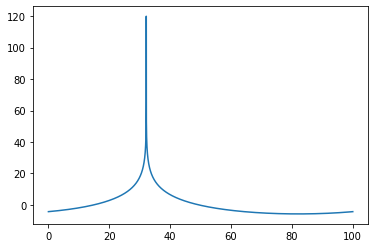

In [7]:
## ploting numpy array is simple and familiar
plot(f,20*np.log10(abs(s)))


Below is the identical code to the numpy code, but all done in the gpu.  This means these arrays are not in the ram. They are in the GPU. To plot them, or do anything to them that uses the cpu, we need to copy the arrays to the cpu.  However, since everything is done on the cpu, it can be very quick!

In [11]:
import cupy as cp

N = 2**20 # something large
dt = .01
df = 1/N/dt

#if we use the cupy library directly, all our arrays are produced on the gpu
tgpu = cp.arange(N)*dt #make a time axis
fgpu = cp.arange(N)*df

egpu = cp.exp(1j*202*tgpu) # make a field

sgpu = cp.fft.fft(egpu) #go to the frequency domain

e2gpu = cp.fft.ifft(sgpu) # go back to time domain


# OK, need to do some new things here... Can't just plot it... will show in next cell

We must transfer the gpu variables to the cpu for plotting.  cupy library provides some great functions cp.asnumpy().

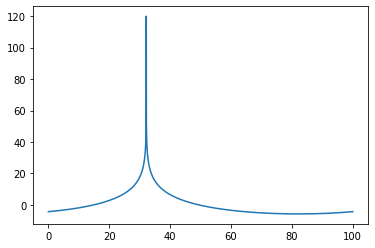

In [12]:
# Move arrays from gpu to the cpu so we can plot with matplotlib
scpu = cp.asnumpy(sgpu)
fcpu = cp.asnumpy(fgpu)

plot(fcpu,20*np.log10(abs(scpu)))

## Transfering data to the gpu
Suppose we already have a numpy array and we need to do some work on the gpu with it.  First we must copy it to the gpu. This is easy with cupy.  use cp.asarray()

In [13]:
sgpu2 = cp.asarray(scpu) # sgpu2 is now on the gpu

## What happens when you try to operate on something on a gpu and a cpu at the same time?

YOU WILL GET AN ERROR!

In [15]:
# this will produce an error
scpu*sgpu

TypeError: Unsupported type <class 'numpy.ndarray'>

# How to get the most speedups with the GPU?  
Keep your prolem on the GPU and only bring data back to the CPU when absoluately neccessary

In [17]:
%%timeit
# This example is slow because we go back and forth between the gpu and the cpu

egpu = cp.asarray(e)
sgpu = cp.fft.fft(egpu)

#do some operation on the cpu
scpu = cp.asnumpy(sgpu)
scpu *= 2. 
# this  is a trivial operation, but it is just meant to show 
# how data transfers can slow you down

# copy back to gpu
sgpu = cp.asarray(scpu) 

egpu = cp.fft.ifft(sgpu)

ecpu = cp.asarray(egpu)


12.4 ms ± 586 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%%timeit
# This example only transfers the data once!
egpu = cp.asarray(e)
sgpu = cp.fft.fft(egpu)

#do that operation on the gpu
sgpu *=2.

egpu = cp.fft.ifft(sgpu)

ecpu = cp.asarray(egpu)


The slowest run took 6.83 times longer than the fastest. This could mean that an intermediate result is being cached.
3.26 ms ± 3.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Because we saved so much time just by eliminating 2 transfers, we can probably assume most of the time in this code is taken up by the data transfer to the GPU.  More sophisiticated code would probably do many more operations and kernel calls before returning the data to the CPU

# More Advanced GPU - CUSTOM KERNELS!!!
CUPY is basically a drop in replacement for numpy.  If you are not doing anything super specific, cupy is so easy that you can make huge speedups in your program! 

Custom kernels should only be used when you can't do it with basic functions.  They are hard to debug, and are difficult to program... You need much more knowledge about the GPU.

For this, I refer you to the cupy documentation -- this kernel adds two vectors together and places the result in a third.  

```python
>>> add_kernel = cp.RawKernel(r'''
... extern "C" __global__
... void my_add(const float* x1, const float* x2, float* y) {
...     int tid = blockDim.x * blockIdx.x + threadIdx.x;
...     y[tid] = x1[tid] + x2[tid];
... }
... ''', 'my_add')
>>> x1 = cp.arange(25, dtype=cp.float32).reshape(5, 5)
>>> x2 = cp.arange(25, dtype=cp.float32).reshape(5, 5)
>>> y = cp.zeros((5, 5), dtype=cp.float32)
>>> add_kernel((5,), (5,), (x1, x2, y))  # grid, block and arguments
>>> y
array([[ 0.,  2.,  4.,  6.,  8.],
       [10., 12., 14., 16., 18.],
       [20., 22., 24., 26., 28.],
       [30., 32., 34., 36., 38.],
       [40., 42., 44., 46., 48.]], dtype=float32)

```


# Here is a custom kernel I wrote

This is meant to serve as an example of how ugly and annoying it is to write a custom kernel.  This one is for a nonuniform fft (e.g., interpolation) which is somewhat more challenging to write for a gpu.

```c
extern "C" __global__
void interpshort(const int nin, //Number of points in input
            const int nout, //Number of points in output
            const int arrays, //Number of arrays to simultaneously process
            const double* outx, // Slows things down a bit.. would need to think of some tricks to avoid using 
            const int* inx, //precomputed lookup that tells us where to pickup data from input array
            const short* x, //values to interpolate. // These inputs
            float *y  //store result in here!
        ) {
     // loop through output array x
     // outx, each index tells the target output positions
     // inx, each index corresponds to an output grid and says which input to look at.

     int   xstart;
     int   xend;
     int   limit;
     float temp;
     
     int ipos;
     int j;
     float pos;
     float wi;
     
     const float tablestep = 1022/8.0f;
     
     __shared__ int loadstart;
     //__shared__ int loadend;
     __shared__ int firsti; 
     
     __shared__ short xdata[2048]; // Some SHARED Memory...
     __shared__ float outxdata[2048]; // Some SHARED Memory...
     __shared__ float table[1024];
     
     //make our lookup table since this was a bottlenek
     table[threadIdx.x] = kernel(-4.0f+threadIdx.x/tablestep);

     __syncthreads();
     
     for (int i = blockIdx.x * blockDim.x + threadIdx.x; 
         i < nout;//-1000000;//-100000;//nout-MSP-2-2000; 
         i += blockDim.x * gridDim.x) 
         {
        //i is our current output
        // xstart and xend are where we need to look in the input array for data.

         //if (i>=MSP) 
         xstart = inx[MAX(i-MSP,0)] + 1;
         //else
         xend   = inx[MIN(i+MSP,nout-1)];


         xstart = MAX(xstart,0);//(xstart<0) ?   0:xstart; // protect input
         xend   = MIN(xend,nin-1);//(xend>nin) ? nin-1:xend; //protect against overflow...  
         
         //Load up the Start point and End Point
         if (threadIdx.x==0) {
             loadstart = xstart;
             firsti = i ;
         }
         if (threadIdx.x==1023) {
            //  loadend = xend;
         }

         __syncthreads();



         
         //load up shared memory.... for the interpolation info
         if ( (loadstart+threadIdx.x ) < nin )
         {
             outxdata[threadIdx.x]            = (outx[loadstart+threadIdx.x]-firsti); //
             
             //Load next block ifneccessary
             if ( (loadstart + threadIdx.x + blockDim.x ) < nin )
             {
                 outxdata[threadIdx.x+blockDim.x] = (outx[loadstart + threadIdx.x + blockDim.x]-firsti);
             }
             else
             {
                 //need to protect bad data gets..
                  outxdata[threadIdx.x+blockDim.x] = nout-1;
             }
         }
         else
         {
             outxdata[threadIdx.x] = nout-1;
         }

         for (int k =0; k<arrays; k++)
         {
            __syncthreads(); // NEED THIS FOR WHEN THE LOOP LOOPS AROUND... If some threads are ahead they could corrupt the data in the sharedbuffer 
            // Load the global memory for this group of threads
            if ( (loadstart+threadIdx.x ) < nin )
            {
                xdata[threadIdx.x]               = x[loadstart + threadIdx.x                  + nin*k];
                
                //Load next block ifneccessary
                if ( (loadstart+threadIdx.x+blockDim.x )<nin )
                {
                    xdata[threadIdx.x+blockDim.x]    = x[loadstart + threadIdx.x + blockDim.x + nin*k];
                }
            }

            __syncthreads();
            
            temp = 0.0f;
            //temp =(i - firsti - outxdata[xend-loadstart]) ;
             for (  j = xstart; j<=xend;  j++)
             {
                 pos = (i - firsti - outxdata[j-loadstart]) *tablestep; // where to interpolate.........            

                  ipos = int(pos);
                  wi = pos-ipos;


                  if (ipos>-513 && ipos < (1024-513))
                  {
                    //sometimes can have a table fault from numerical mistakes...
                    temp +=  (table[ipos+512]*(1.0f-wi) + wi*table[ipos+513])*xdata[j-loadstart]*(outxdata[j-loadstart+1]-outxdata[j-loadstart]);
                  }

            //    // Non interpolating version is a little slower...
            //     if (abs(i-firsti-outxdata[j-loadstart])<4.0f)
            //     {
            //      temp += kernel(i-firsti-outxdata[j-loadstart])*xdata[j-loadstart];
            //     }

             }

             //hopefully this one is am
             y[i + k*nout] = temp;//temp;


         }
         }
}
```